In [2]:
import glob
import numpy
import pandas
import seaborn
import matplotlib.pyplot as plt
from tqdm import tqdm
import multiprocessing as mp
import os
from build import build_model
from diets import load_model
import coralme
pandas.set_option('display.max_colwidth', None)

In [3]:
from IPython.display import display, HTML, Math, Markdown
display(HTML("<style>.container { width:95% !important; }</style>"))

%load_ext autoreload
%autoreload 2

### Set organisms

In [3]:
# !bash report.sh
organisms = set(pandas.read_csv("survivors.txt",index_col=0,header=None).index.to_list())
# done = set(pandas.read_csv("biomass_constrained.txt",index_col=0,header=None).index.to_list())
done = set(i.split(".csv")[0] for i in os.listdir("./fluxes_reconstruction/me/") if "checkpoint" not in i)

In [4]:
run_for = list(done)
len(run_for)

497

In [5]:
len(done)

497

### Load

In [6]:
from tqdm import tqdm
conditions = ["base"]
def load_data(path,org):
    try:
        df = pandas.read_csv(path,index_col=0)[["fluxes"]]
    except:
        df = pandas.DataFrame(columns=["fluxes"])
    df.columns = [org]
    return df

def load_growth(folder):
    growth = {i:{} for i in conditions}
    for org in tqdm(organisms):
        for c in conditions:
            tmp = load_data("./{}/fluxes/{}/{}.csv".format(folder,c,org),org)
            if tmp.empty:
                val = 0
            else:
                val = tmp[org]["biomass_dilution"]
            growth[c][org] = val
    return pandas.DataFrame.from_dict(growth)

In [7]:
HFD = load_growth("cases-HFD")

100%|█████████████████████████████████████████████████████████████████████████████████| 497/497 [00:11<00:00, 44.10it/s]


In [8]:
WD = load_growth("cases")

100%|████████████████████████████████████████████████████████████████████████████████| 497/497 [00:01<00:00, 276.86it/s]


In [9]:
df = WD.join(HFD,lsuffix="WD",rsuffix="HFD")

In [10]:
df.sort_values("baseHFD")

,baseWD,baseHFD
Tropheryma_whipplei_str_Twist,0.030142,0.001056
Campylobacter_fetus_subsp_fetus_82_40,0.002236,0.001085
Campylobacter_hominis_ATCC_BAA_381,0.001739,0.001739
Adlercreutzia_equolifaciens_DSM_19450,0.021663,0.001915
Dialister_invisus_DSM_15470,0.081222,0.002238
...,...,...
Enterobacter_aerogenes_KCTC_2190,0.579561,0.536741
Escherichia_albertii_TW07627,0.601763,0.545515
Pseudomonas_aeruginosa_NCGM2_S1,0.578394,0.571149
Escherichia_fergusonii_ATCC_35469,0.635045,0.631708


### Classify

In [5]:
growth = df[["baseWD"]]
growth.columns = ["base"]
growth = growth[growth["base"]>0]

NameError: name 'df' is not defined

In [6]:
taxonomy = pandas.read_csv("./taxonomy.txt",index_col=0,sep='\t')
taxa = "Phylum"

<ErrorbarContainer object of 3 artists>

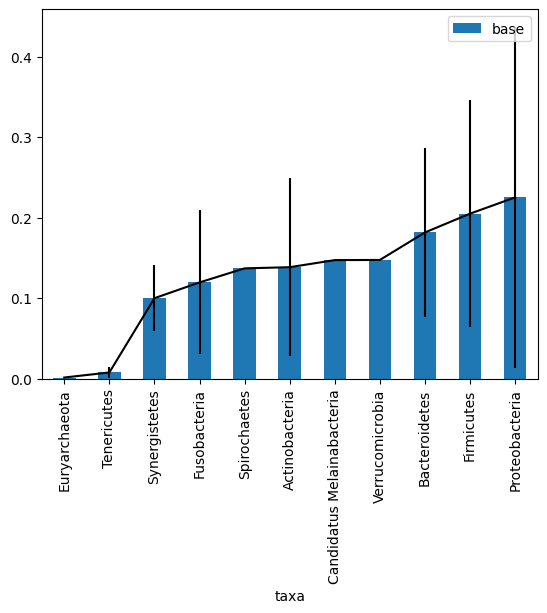

In [13]:
growth["taxa"] = taxonomy[taxa]
mean = growth.groupby("taxa").mean().sort_values("base").fillna(0.)
std = growth.groupby("taxa").std().sort_values("base").fillna(0.)

fig,ax = plt.subplots(1,1)
mean.plot.bar(ax=ax)
ax.errorbar(x=mean.index,y=mean["base"][mean.index],yerr=std["base"][mean.index],color='k')

In [14]:
wd = mean

### Classify

In [15]:
growth = df[["baseHFD"]]
growth.columns = ["base"]
growth = growth[growth["base"]>0]

In [16]:
taxonomy = pandas.read_csv("./taxonomy.txt",index_col=0,sep='\t')
taxa = "Phylum"

<ErrorbarContainer object of 3 artists>

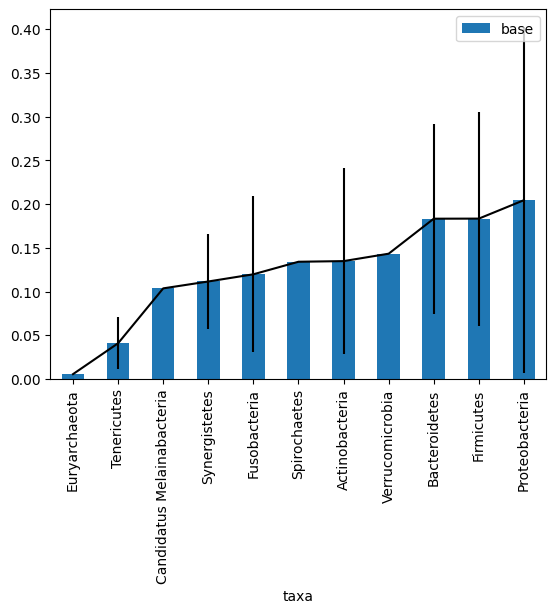

In [17]:
growth["taxa"] = taxonomy[taxa]
mean = growth.groupby("taxa").mean().sort_values("base").fillna(0.)
std = growth.groupby("taxa").std().sort_values("base").fillna(0.)

fig,ax = plt.subplots(1,1)
mean.plot.bar(ax=ax)
ax.errorbar(x=mean.index,y=mean["base"][mean.index],yerr=std["base"][mean.index],color='k')

In [18]:
hfd = mean

In [19]:
tmp = pandas.concat([wd.rename(columns={"base":"WD"}),hfd.rename(columns={"base":"HFD"})],axis=1)

<Axes: xlabel='taxa'>

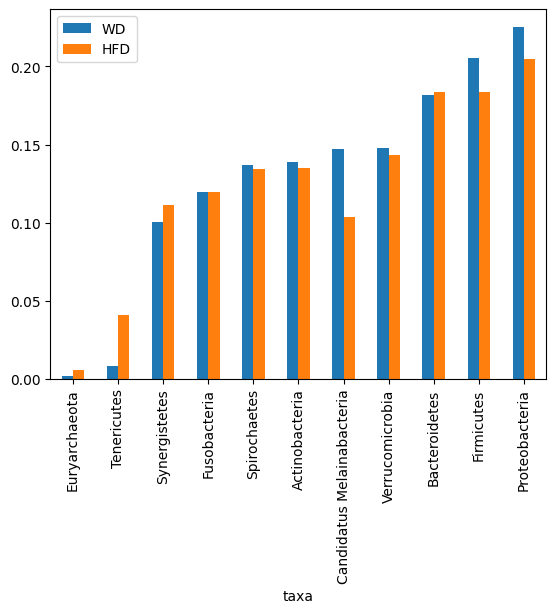

In [20]:
tmp.plot.bar()